In [2]:
!pip install pyod
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from scipy import stats
from pyod.models.iforest import IForest
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns",100)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.0-py3-none-any.whl size=185329 sha256=477118829c8c2493932c794bcb050dfdeaed850c50079d150a79724035ded0d3
  Stored in directory: /root/.cache/pip/wheels/36/8e/e2/e932956b10b843eb6be9eefa70b5c1bee7b561be14c423b136
Successfully built pyod


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/capstone project

/content/drive/MyDrive/capstone project


In [6]:
df= pd.read_csv('NF-ToN-IoT.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379274 entries, 0 to 1379273
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   IPV4_SRC_ADDR               1379274 non-null  object 
 1   L4_SRC_PORT                 1379274 non-null  int64  
 2   IPV4_DST_ADDR               1379274 non-null  object 
 3   L4_DST_PORT                 1379274 non-null  int64  
 4   PROTOCOL                    1379274 non-null  int64  
 5   L7_PROTO                    1379274 non-null  float64
 6   IN_BYTES                    1379274 non-null  int64  
 7   OUT_BYTES                   1379274 non-null  int64  
 8   IN_PKTS                     1379274 non-null  int64  
 9   OUT_PKTS                    1379274 non-null  int64  
 10  TCP_FLAGS                   1379274 non-null  int64  
 11  FLOW_DURATION_MILLISECONDS  1379274 non-null  int64  
 12  Label                       1379274 non-null  int64  
 1

In [8]:
df = df_shrink(df, obj2cat=False, int2uint=False)

In [9]:
df['Label'] = df['Label'].astype("category")
df['PROTOCOL'] = df['PROTOCOL'].astype("category")
df['Attack'] = df['Attack'].astype("category")
df['L4_SRC_PORT'] = df['L4_SRC_PORT'].astype("category")
df['L4_DST_PORT'] = df['L4_DST_PORT'].astype("category")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379274 entries, 0 to 1379273
Data columns (total 14 columns):
 #   Column                      Non-Null Count    Dtype   
---  ------                      --------------    -----   
 0   IPV4_SRC_ADDR               1379274 non-null  object  
 1   L4_SRC_PORT                 1379274 non-null  category
 2   IPV4_DST_ADDR               1379274 non-null  object  
 3   L4_DST_PORT                 1379274 non-null  category
 4   PROTOCOL                    1379274 non-null  category
 5   L7_PROTO                    1379274 non-null  float32 
 6   IN_BYTES                    1379274 non-null  int32   
 7   OUT_BYTES                   1379274 non-null  int32   
 8   IN_PKTS                     1379274 non-null  int32   
 9   OUT_PKTS                    1379274 non-null  int32   
 10  TCP_FLAGS                   1379274 non-null  int16   
 11  FLOW_DURATION_MILLISECONDS  1379274 non-null  int32   
 12  Label                       1379274 non-nu

In [11]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
L7_PROTO,1379274.0,32.09,40.88,0.0,7.0,7.0,91.0,251.0
IN_BYTES,1379274.0,1466.23,177963.17,28.0,112.0,458.0,554.0,79415904.0
OUT_BYTES,1379274.0,2745.43,110558.95,0.0,60.0,696.0,2239.0,70165175.0
IN_PKTS,1379274.0,18.01,2885.74,1.0,2.0,4.0,5.0,1221043.0
OUT_PKTS,1379274.0,10.71,1454.47,0.0,1.0,4.0,6.0,1349068.0
TCP_FLAGS,1379274.0,21.22,8.20,0.0,18.0,26.0,27.0,219.0
FLOW_DURATION_MILLISECONDS,1379274.0,6633.70,119731.99,0.0,0.0,94.0,382.0,4294849.0


In [12]:
df.describe(include='object')

,IPV4_SRC_ADDR,IPV4_DST_ADDR
count,1379274,1379274
unique,174,1478
top,192.168.1.31,192.168.1.190
freq,269925,287600


In [13]:
df.describe(include='category')

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,Label,Attack
count,1379274,1379274,1379274,1379274,1379274
unique,38857,16071,5,2,10
top,443,80,6,1,injection
freq,113095,807696,1251484,1108995,468539


In [14]:
df = df.drop_duplicates(keep='last')

In [15]:
df.duplicated().sum()

0

In [16]:
df.shape

(1210929, 14)

In [ ]:
df.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,Label,Attack,FLOW_DURATION_SECONDS
0,192.168.1.195,63318,52.139.250.253,443,6,91.000000,181,165,2,1,24,0,Benign,0.327
1,192.168.1.79,57442,192.168.1.255,15600,17,0.000000,63,0,1,0,0,0,Benign,0.000
2,192.168.1.79,57452,239.255.255.250,15600,17,0.000000,63,0,1,0,0,0,Benign,0.000
4,192.168.1.79,51989,192.168.1.255,15600,17,0.000000,63,0,1,0,0,0,Benign,0.000
5,192.168.1.6,53927,239.255.255.250,1900,17,153.119995,459,0,3,0,0,0,Benign,0.614


In [18]:
px.histogram(data_frame=df,x='Attack')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
px.histogram(data_frame=df,x='Label')
#1 attack ,0 normal

Output hidden; open in https://colab.research.google.com to view.

In [20]:
protocol_attack = df.groupby("PROTOCOL")['Attack'].count()

In [ ]:
protocol_attack

PROTOCOL
1         312
2         878
6     1095432
17     114253
58         54
Name: Attack, dtype: int64

#### PROTOCOL 6 : Transmission Control Protocol (TCP), it is responsible for establishing and maintaining connections between devices on a network.
#### PROTOCOL 17 : User Datagram Protocol (UDP), operating at the transport layer of the OSI model. Unlike TCP, UDP is a connectionless protocol that does not provide reliable, ordered delivery of data packets.

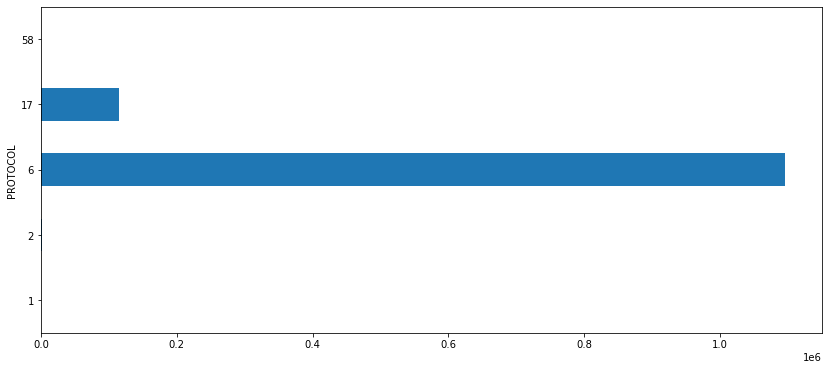

In [ ]:
protocol_attack.plot(kind='barh',figsize=(14,6));

In [ ]:
df['TCP_FLAGS'].value_counts()

27     615538
18     179546
0      115497
17      87227
31      52032
19      38902
25      35526
16      25909
26      25878
22      19001
24       9009
2        3901
30       1544
29        645
21        419
20        200
28        131
6           6
214         5
23          4
4           3
215         2
211         2
219         2
Name: TCP_FLAGS, dtype: int64

In [21]:
px.histogram(data_frame=df,x='TCP_FLAGS')

Output hidden; open in https://colab.research.google.com to view.

In [22]:
px.scatter(data_frame=df,x='TCP_FLAGS',y='OUT_BYTES')

Output hidden; open in https://colab.research.google.com to view.

In [23]:
address_src_port =  df.groupby("IPV4_SRC_ADDR")['L4_SRC_PORT'].count()

In [24]:
px.histogram(data_frame=address_src_port)

In [25]:
address_dst_port =  df.groupby("IPV4_DST_ADDR")['L4_DST_PORT'].count()

In [26]:
px.histogram(data_frame=address_dst_port)